In [59]:
# !open .

In [68]:
import pandas as pd
import requests
import bs4
import math
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def request_price_list(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_list = pd.to_numeric(price_list)
    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    price_df.index = pd.to_datetime(price_df.index)
    
    return price_df

def get_company_list(kospi = True):
    if kospi == True: 
        file_loc = 'data/kospi.xlsx'
    else:
        file_loc = 'data/kosdaq.xlsx'

    company = pd.read_excel(file_loc)
    company.code = company.code.map('{:06d}'.format)
    company = company.set_index(company.columns[0])
    return company

def get_all_company_list():
    kospi = get_company_list(True)
    kosdaq = get_company_list(False)
    kospi['type'] = 'kospi'
    kosdaq['type'] = 'kosdaq'
    companies = pd.concat([kospi, kosdaq], sort=False)
    return companies

def get_company_code(name, company_df):
    return company_df[company_df['company'] == name].index[0]


def get_total_stock_count(snapshot_tables):
    stock_count = 0

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])
    stock_count_info = info.loc['발행주식수(보통주/ 우선주)'][1]
    stock_counts = stock_count_info.split('/')
    for count in stock_counts:
#         print(count)
        stock_count = stock_count + int(count.replace(',',''))

    return stock_count

def get_self_stock_count(snapshot_tables):
    self_stock_count = 0
    info = snapshot_tables[4]
    info = info.set_index(info.columns[0])
    count = info.loc[['자기주식\xa0(자사주+자사주신탁)']]['보통주'][0]
#     print(count)
    if not math.isnan(count):
        self_stock_count = int(count)
    return self_stock_count


def get_standard_col_name(snapshot_tables):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    asset_index_name = '지배주주지분'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    stadard_col_name = ''
    roes = info.loc[roe_index_name][big_col_name]
    assets = info.loc[asset_index_name][big_col_name]
    for index in reversed(assets.index):
        if not math.isnan(assets[index]) and not math.isnan(roes[index]):
            stadard_col_name = index
            break
    return stadard_col_name

def get_roe(snapshot_tables, stadard_col_name):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    roe = info.loc[roe_index_name][big_col_name, stadard_col_name]
    return roe

def get_asset(snapshot_tables, stadard_col_name):
    big_col_name = 'Annual'
    asset_index_name = '지배주주지분'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    asset = info.loc[asset_index_name][big_col_name, stadard_col_name]
    asset = asset * 100000000
    return asset

def get_adequate_price(asset, roe, expected_ratio, stock_count, persist_factor = 1):
    excess_profit = (roe - expected_ratio) * asset / 100
#     print(excess_profit)
    accumulate_profit = (persist_factor * excess_profit) / (1 + expected_ratio / 100 - persist_factor)
    adequate_stock_price = asset + accumulate_profit
#     print(adequate_stock_price)
    price = (asset + accumulate_profit) / stock_count
    price = int(round(price))
    return price

def get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration = 10):
    next_asset = asset
    ex_profits = []
    ex_profit_ratio = roe - expected_ratio
    next_roe = roe
    for _ in range(iteration):
        ex_profit_ratio = ex_profit_ratio * persist_factor
        next_roe = expected_ratio + ex_profit_ratio
        profit = next_asset * (next_roe / 100)
        ex_profit = next_asset * ex_profit_ratio / 100
        ex_profits.append(ex_profit)
        next_asset = next_asset + profit
    return ex_profits
def get_npv_profit(ex_profits, expected_ratio):
    npv_value = 0
    for num, ex_profit in enumerate(ex_profits):
        ex_profit = ex_profit *  1 / (1 + expected_ratio / 100) ** (num + 1)
#         print(ex_profit)
        npv_value = npv_value + ex_profit

    return npv_value

def get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration = 10):
    ex_profits = get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration)
    sum_of_profit = get_npv_profit(ex_profits, expected_ratio)
    return sum_of_profit

def get_more_adequate_price(asset, roe, expected_ratio, stock_count, persist_factor = 1, iteration = 10):
    accumulate_profit = get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration)
    adequate_stock_price = asset + accumulate_profit
    price = (asset + accumulate_profit) / stock_count
    price = int(round(price))
    return price

def show_price_chart(company_code, company_name, price_df):
    plt.figure(figsize=(20, 12))
    plt.plot(price_df.index, price_df[company_code], color='darkblue',linewidth=1.0)
    plt.plot(price_df.index, price_df['price_low'], color='blue',linewidth=3.0)
    plt.plot(price_df.index, price_df['price_middle'], color='green',linewidth=3.0)
    plt.plot(price_df.index, price_df['price_high'], color='red',linewidth=3.0)
    plt.title(company_name)
    plt.xlabel("duration")
    plt.ylabel("price")
    # plt.legend(loc='upper right')
    # plt.grid()
    plt.show() 
    
def get_snapshot_from_fnguide(company_code):
    company_code = get_company_code(company_name, companies)
#     print('firm name : ' + company_name)
#     print('firm code : ' + company_code)

    if not company_code.startswith('A'):
        company_code = 'A' + company_code

    snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + company_code
    snapshot_page = requests.get(snapshot_url)
    snapshot_tables = pd.read_html(snapshot_page.text)
    return snapshot_tables

def show_adequate_price_chart(company_name):
    company_code = get_company_code(company_name, companies)
    print('firm name : ' + company_name)
    print('firm code : ' + company_code)

    if not company_code.startswith('A'):
        company_code = 'A' + company_code

    snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + company_code
    snapshot_page = requests.get(snapshot_url)
    snapshot_tables = pd.read_html(snapshot_page.text)
    
    stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
    print('stock count : ' + str(stock_count))
    
    stadard_col_name = get_standard_col_name(snapshot_tables)
    roe =  get_roe(snapshot_tables, stadard_col_name)
    asset = get_asset(snapshot_tables, stadard_col_name)
    print('standard date : ' + stadard_col_name)
    print('asset : ' + str(asset))
    print('roe : ' + str(roe))
    
    price_high = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    price_middel = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
    price_low = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)

    print('buy : below ' + str(price_low))
    print('sell 1/3 : ' + str(price_middel))
    print('sell 1/3 : ' + str(price_high))
    
    price_df = request_price_list(company_code, 'day', 1000)

    price_df['price_low'] = [price_low] * len(price_df)
    price_df['price_middle'] = [price_middel] * len(price_df)
    price_df['price_high'] = [price_high] * len(price_df)
    
    show_price_chart(company_code, company_name, price_df)
    

In [66]:
def show_more_adequate_price_chart(company_name, companies):
    company_code = get_company_code(company_name, companies)
    print('company name : ' + company_name)
    print('company code : ' + company_code)

    snapshot_tables = get_snapshot_from_fnguide(company_code)
    
    stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
    print('stock count : ' + str(stock_count))
    
    stadard_col_name = get_standard_col_name(snapshot_tables)
    roe =  get_roe(snapshot_tables, stadard_col_name)
    asset = get_asset(snapshot_tables, stadard_col_name)
    print('standard date : ' + stadard_col_name)
    print('asset : ' + str(asset))
    print('roe : ' + str(roe))
    
    price_high = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
    price_middel = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
    price_low = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)

    print('buy : below ' + str(price_low))
    print('sell 1/3 : ' + str(price_middel))
    print('sell 1/3 : ' + str(price_high))
    
    price_df = request_price_list(company_code, 'day', 1000)

    price_df['price_low'] = [price_low] * len(price_df)
    price_df['price_middle'] = [price_middel] * len(price_df)
    price_df['price_high'] = [price_high] * len(price_df)
    
    show_price_chart(company_code, company_name, price_df)


## get all company list

In [62]:
companies = get_all_company_list()

## bond spread

In [63]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

In [64]:
company_list = ['서희건설', '키움증권', '한국자산신탁', '유진증권', '메리츠증권', '메리츠화재', '현대건설', 
                'GS건설', '동원개발', 'HDC현대산업개발', '삼성증권', '미래에셋대우', '이베스트투자증권']

company name : 서희건설
company code : 035890
stock count : 222014635
standard date : 2019/12
asset : 378200000000.0
roe : 18.62
buy : below 2408
sell 1/3 : 2995
sell 1/3 : 4388


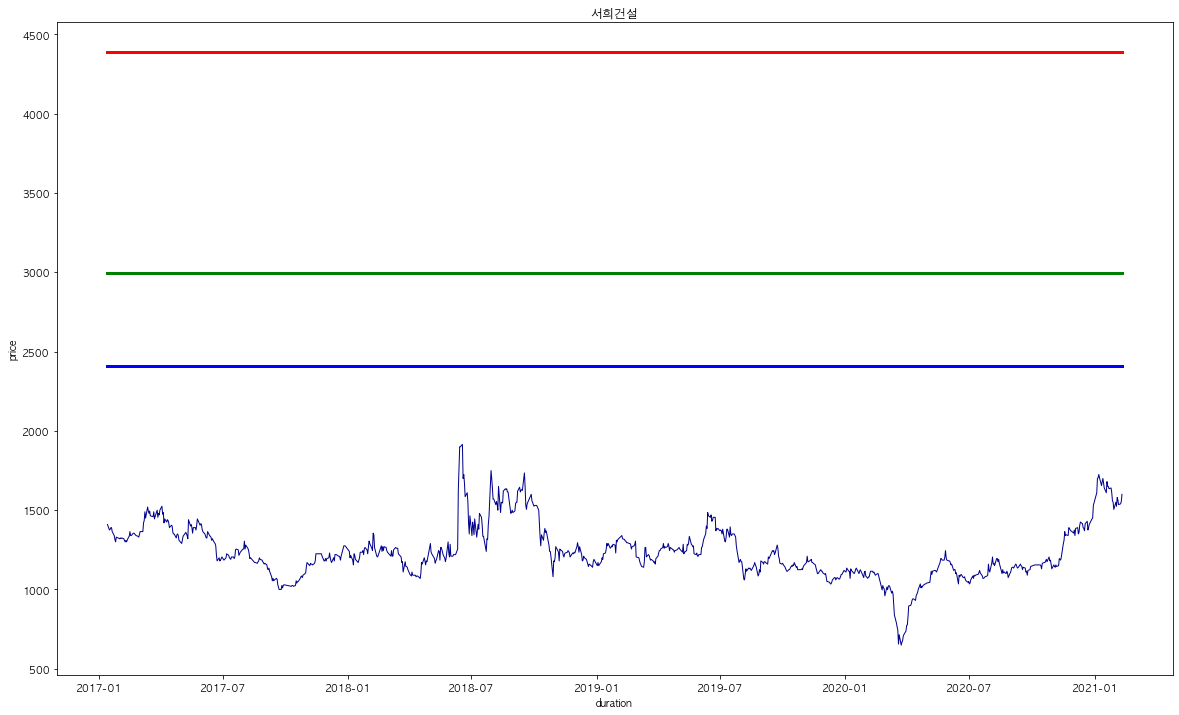

company name : 키움증권
company code : 039490
stock count : 25213100
standard date : 2019/12
asset : 2234000000000.0
roe : 16.97
buy : below 118862
sell 1/3 : 143112
sell 1/3 : 198420


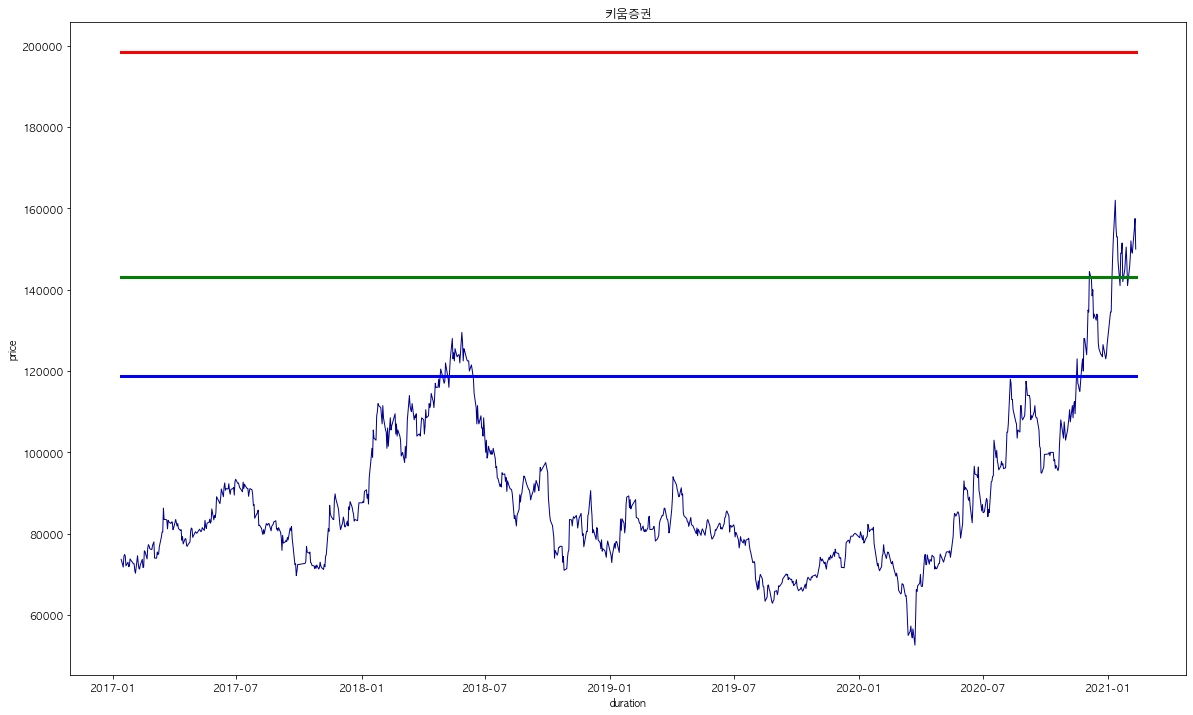

company name : 한국자산신탁
company code : 123890
stock count : 122367055
standard date : 2019/12
asset : 662000000000.0
roe : 14.28
buy : below 6659
sell 1/3 : 7598
sell 1/3 : 9600


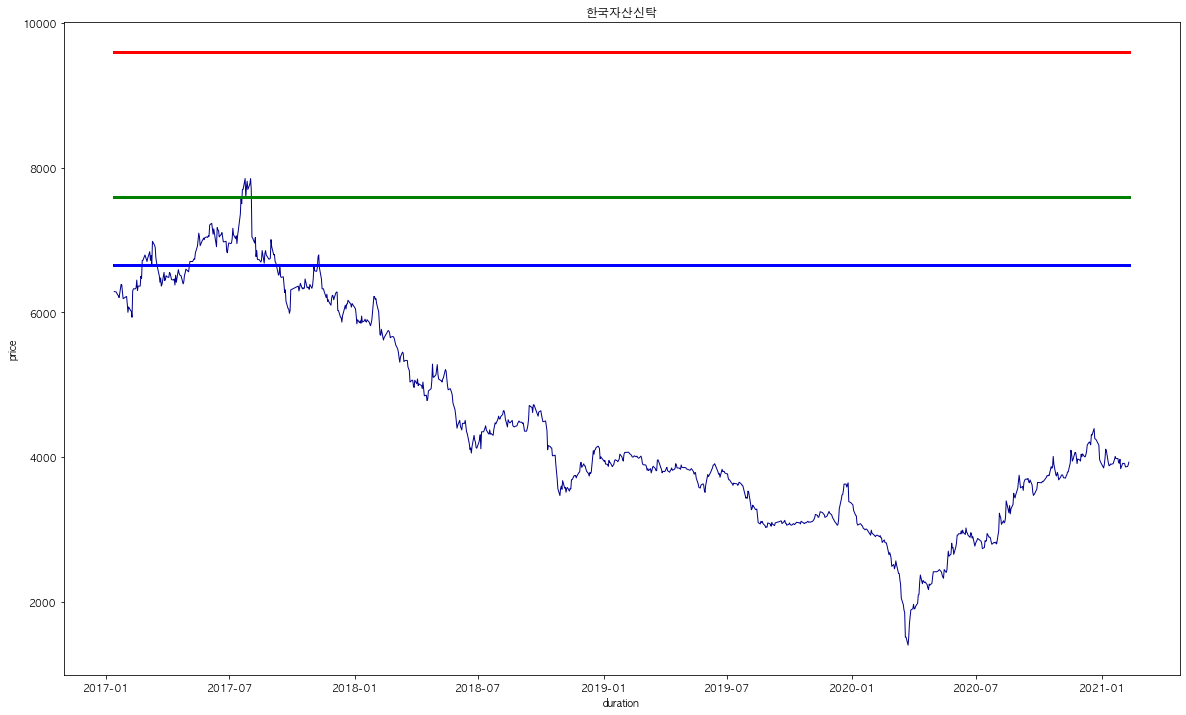

company name : 유진증권
company code : 001200
stock count : 93839145
standard date : 2019/12
asset : 789600000000.0
roe : 5.36
buy : below 7730
sell 1/3 : 7318
sell 1/3 : 6625


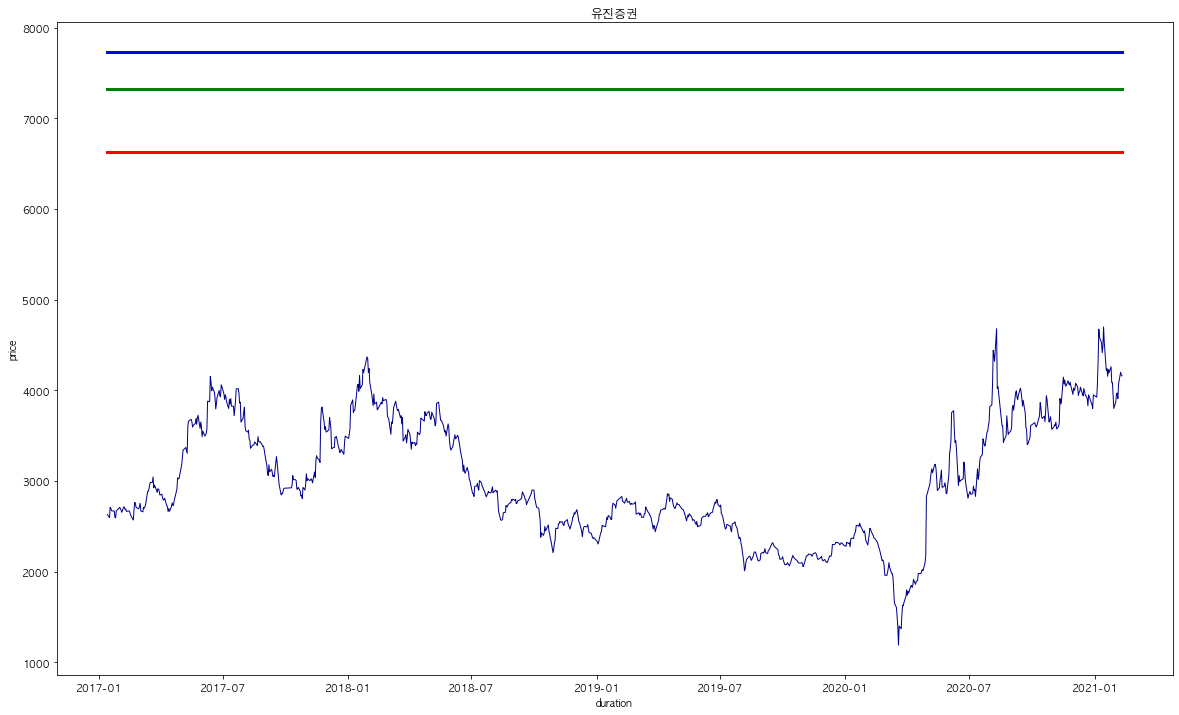

company name : 메리츠증권
company code : 008560
stock count : 703762608
standard date : 2019/12
asset : 3919500000000.0
roe : 15.06
buy : below 7029
sell 1/3 : 8147
sell 1/3 : 10579


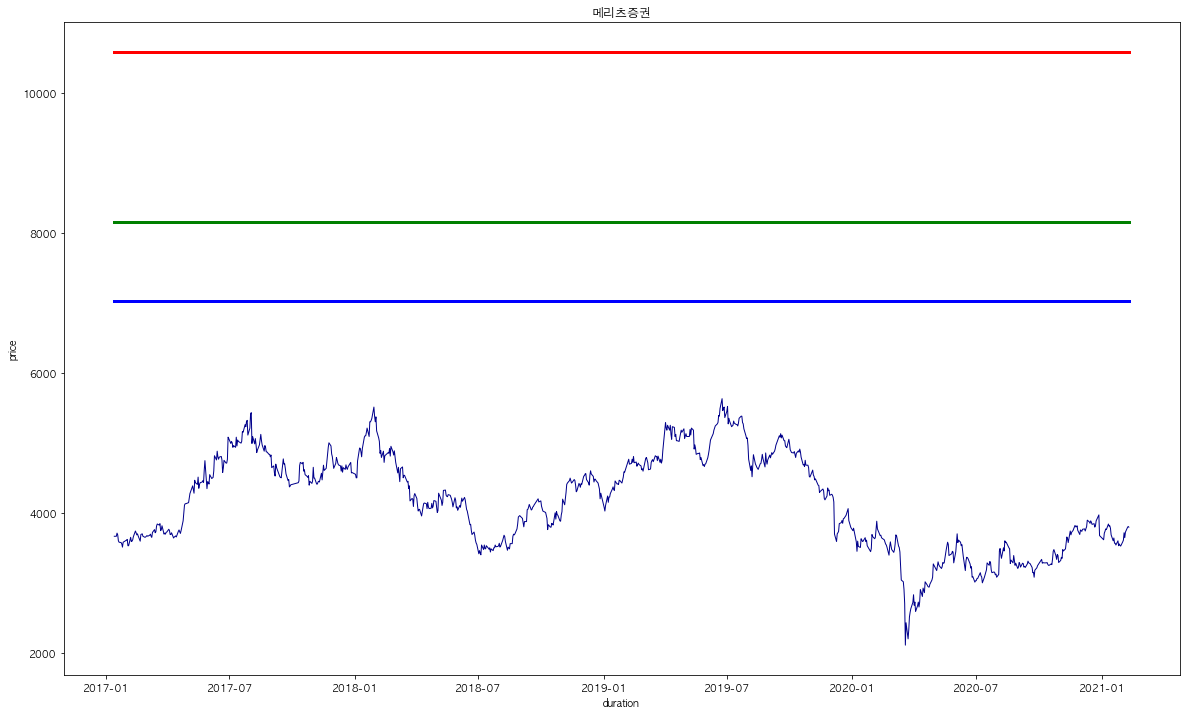

company name : 메리츠화재
company code : 000060
stock count : 118024178
standard date : 2019/12
asset : 2432400000000.0
roe : 12.76
buy : below 24155
sell 1/3 : 26722
sell 1/3 : 31989


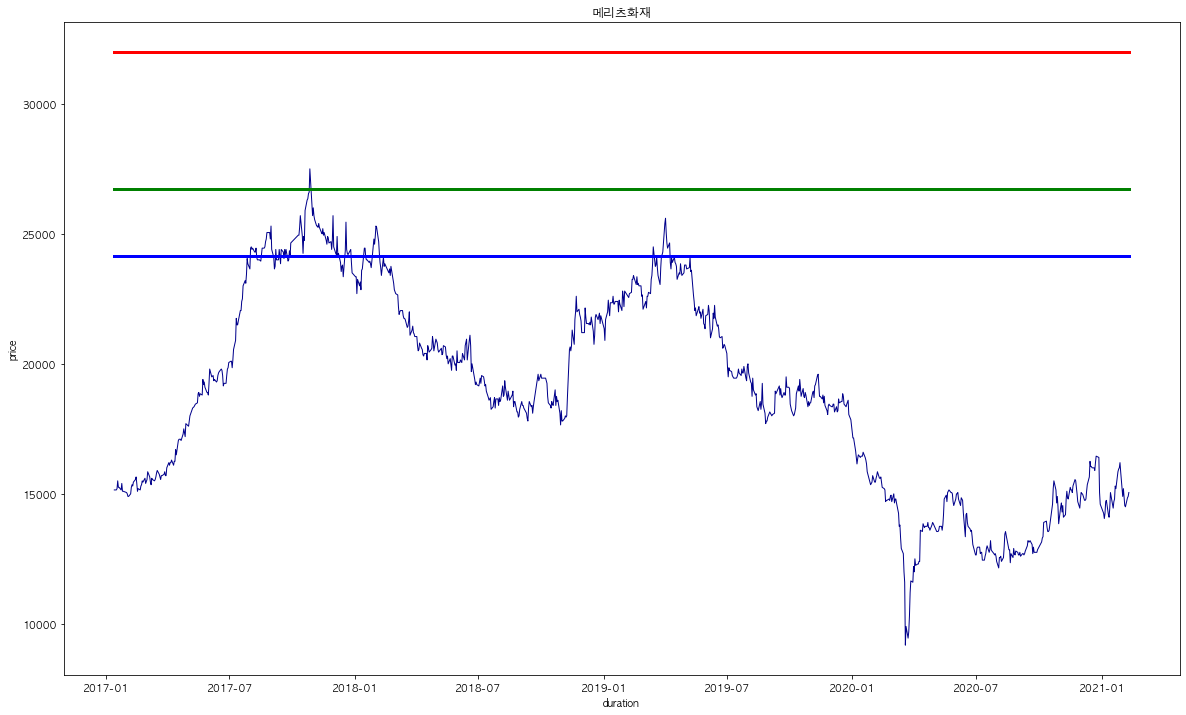

company name : 현대건설
company code : 000720
stock count : 111454621
standard date : 2019/12
asset : 6662600000000.0
roe : 6.3
buy : below 56666
sell 1/3 : 54750
sell 1/3 : 51435


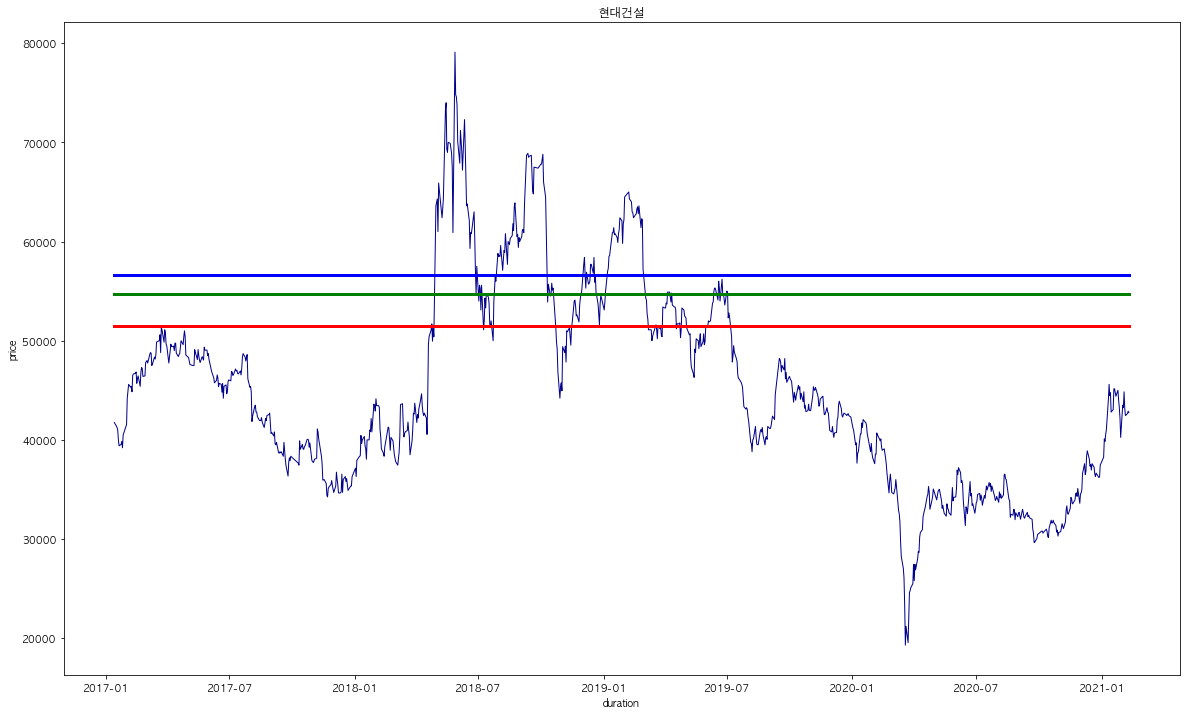

company name : GS건설
company code : 006360
stock count : 80727621
standard date : 2019/12
asset : 3974700000000.0
roe : 11.79
buy : below 55918
sell 1/3 : 60643
sell 1/3 : 70096


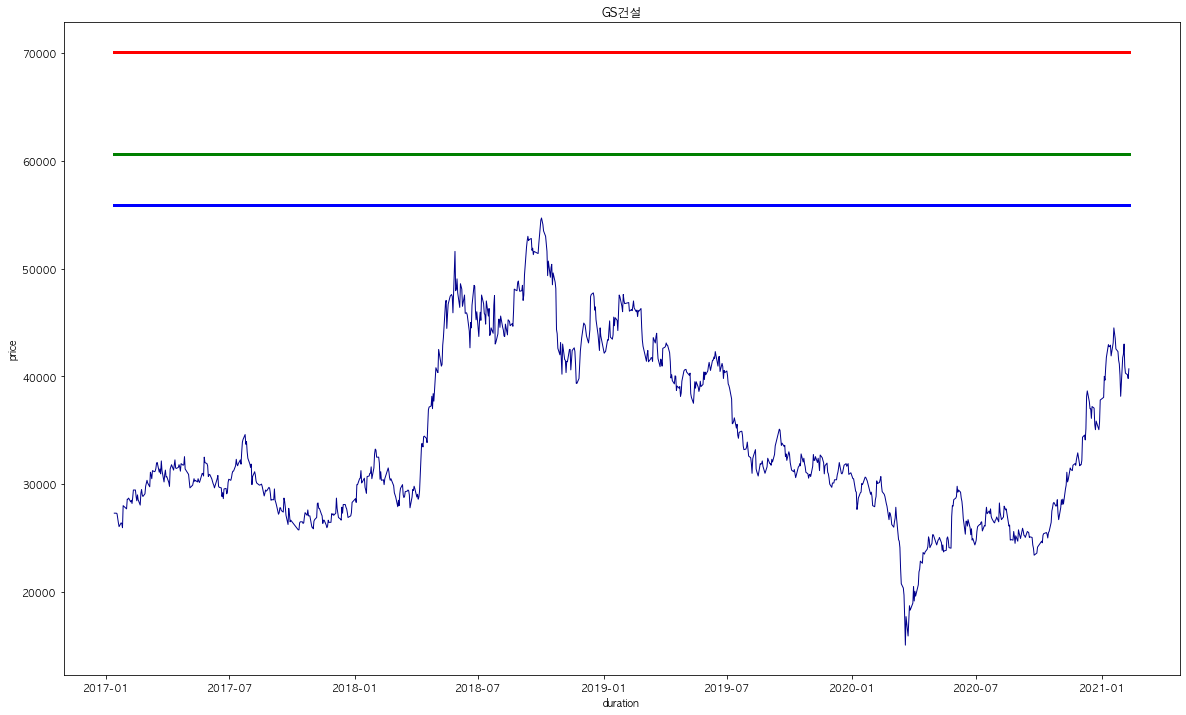

company name : 동원개발
company code : 013120
stock count : 90808100
standard date : 2019/12
asset : 771100000000.0
roe : 11.49
buy : below 9550
sell 1/3 : 10293
sell 1/3 : 11769


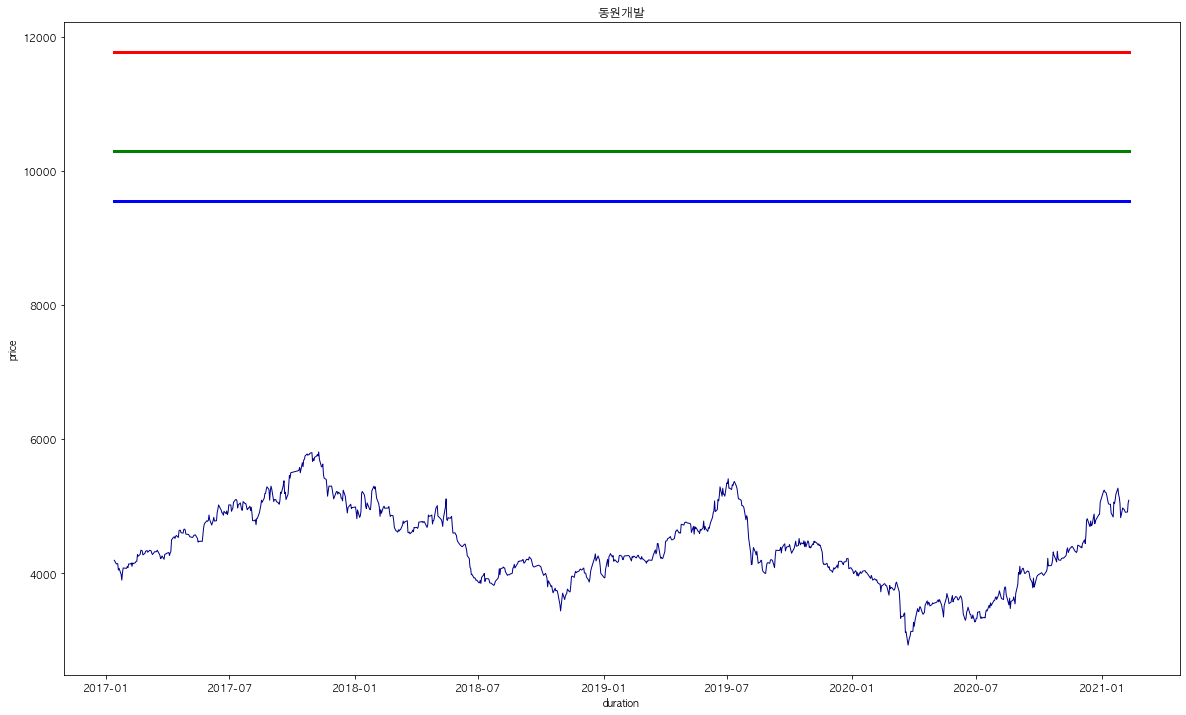

company name : HDC현대산업개발
company code : 294870
stock count : 65897860
standard date : 2019/12
asset : 2231700000000.0
roe : 20.3
buy : below 50465
sell 1/3 : 64845
sell 1/3 : 100416


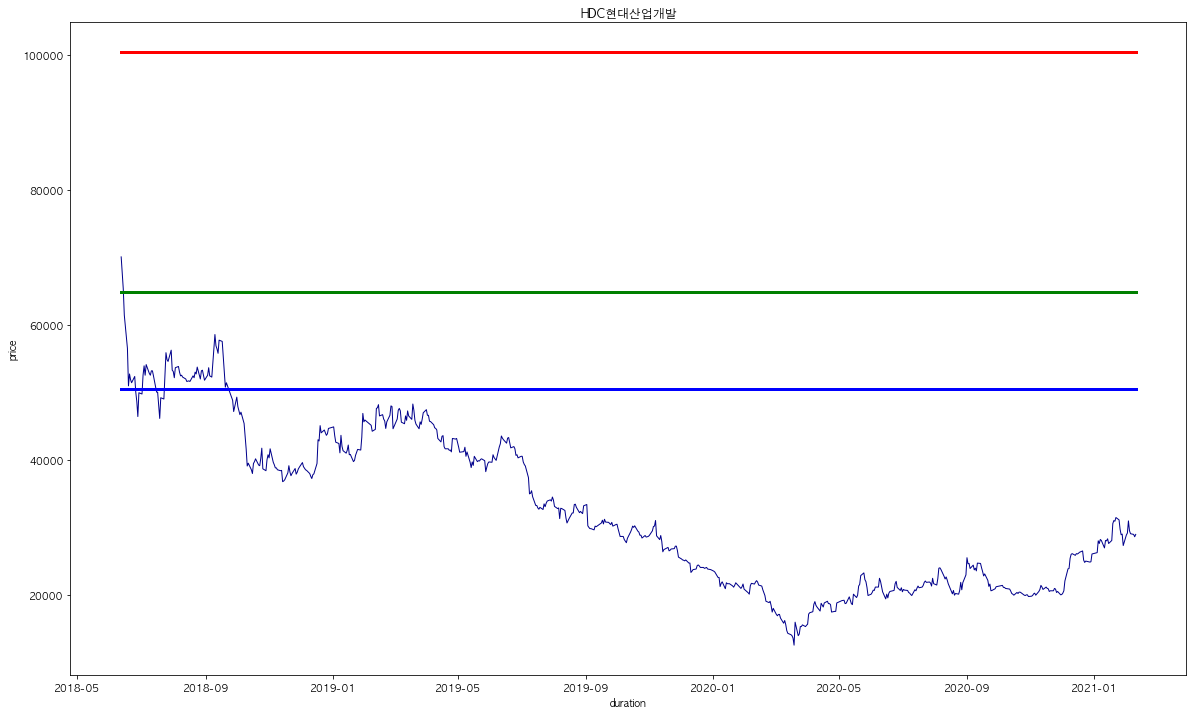

company name : 삼성증권
company code : 016360
stock count : 89300000
standard date : 2019/12
asset : 4949300000000.0
roe : 8.15
buy : below 55865
sell 1/3 : 56150
sell 1/3 : 56668


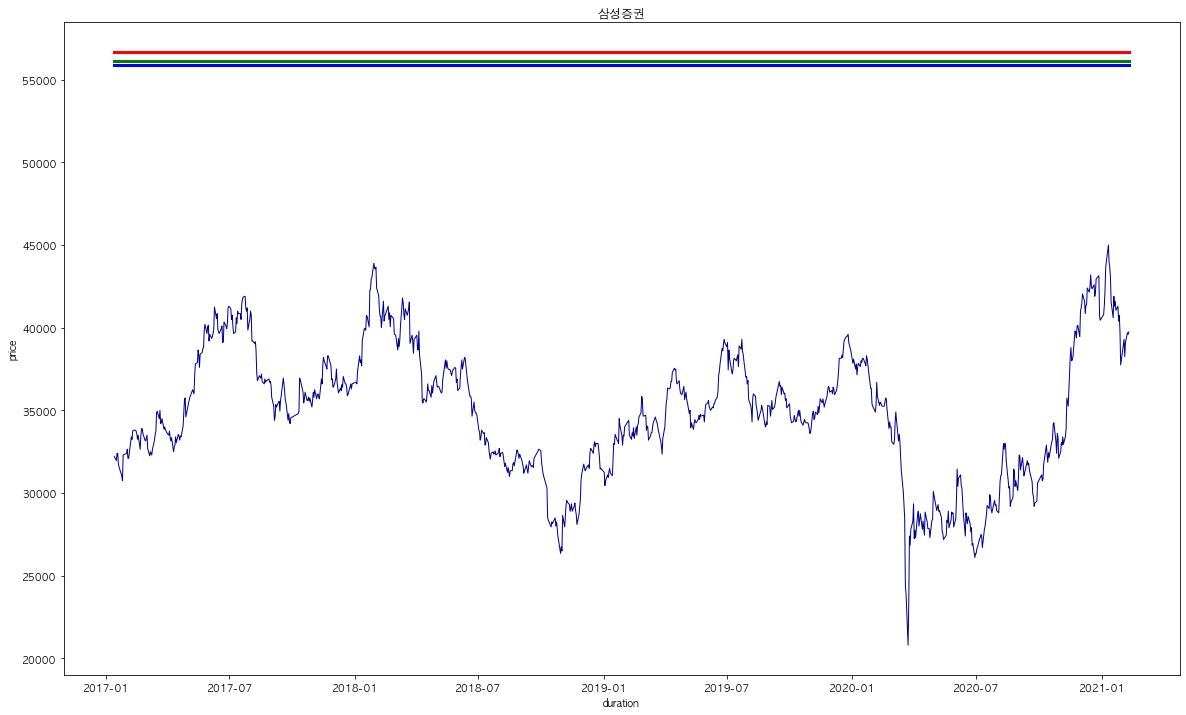

company name : 미래에셋대우
company code : 006800
stock count : 650814253
standard date : 2019/12
asset : 9127800000000.0
roe : 7.56
buy : below 13864
sell 1/3 : 13761
sell 1/3 : 13577


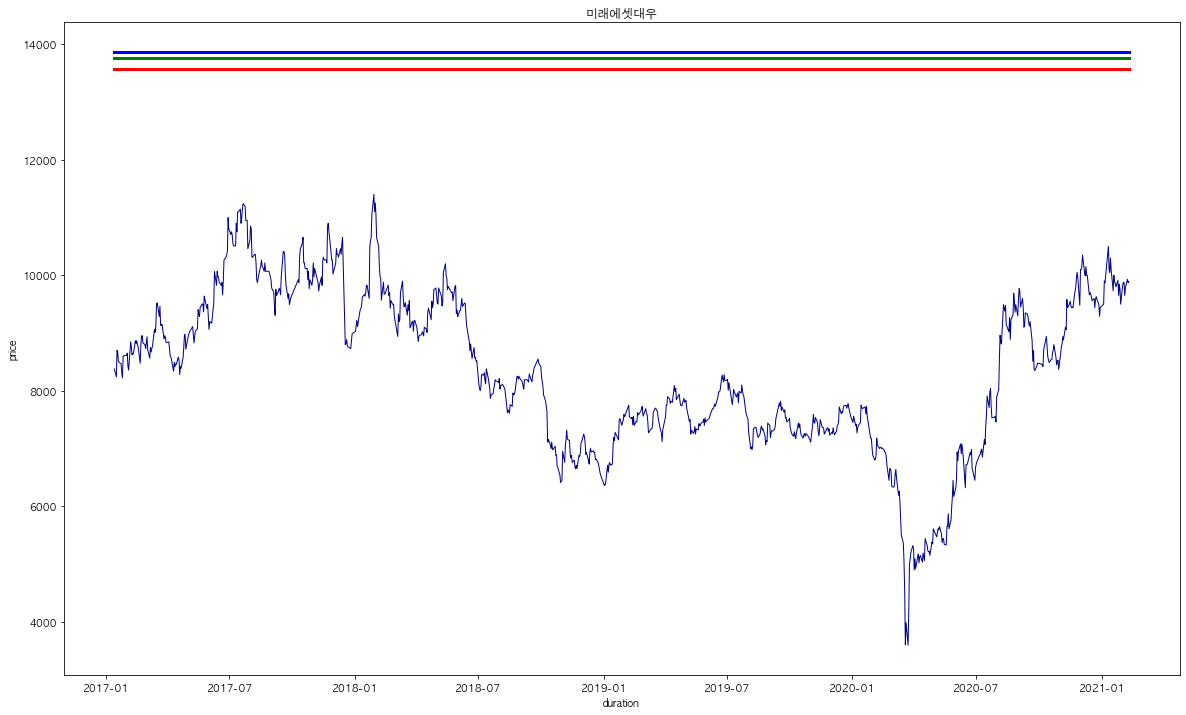

company name : 이베스트투자증권
company code : 078020
stock count : 61947482
standard date : 2019/12
asset : 514000000000.0
roe : 11.23
buy : below 9253
sell 1/3 : 9920
sell 1/3 : 11234


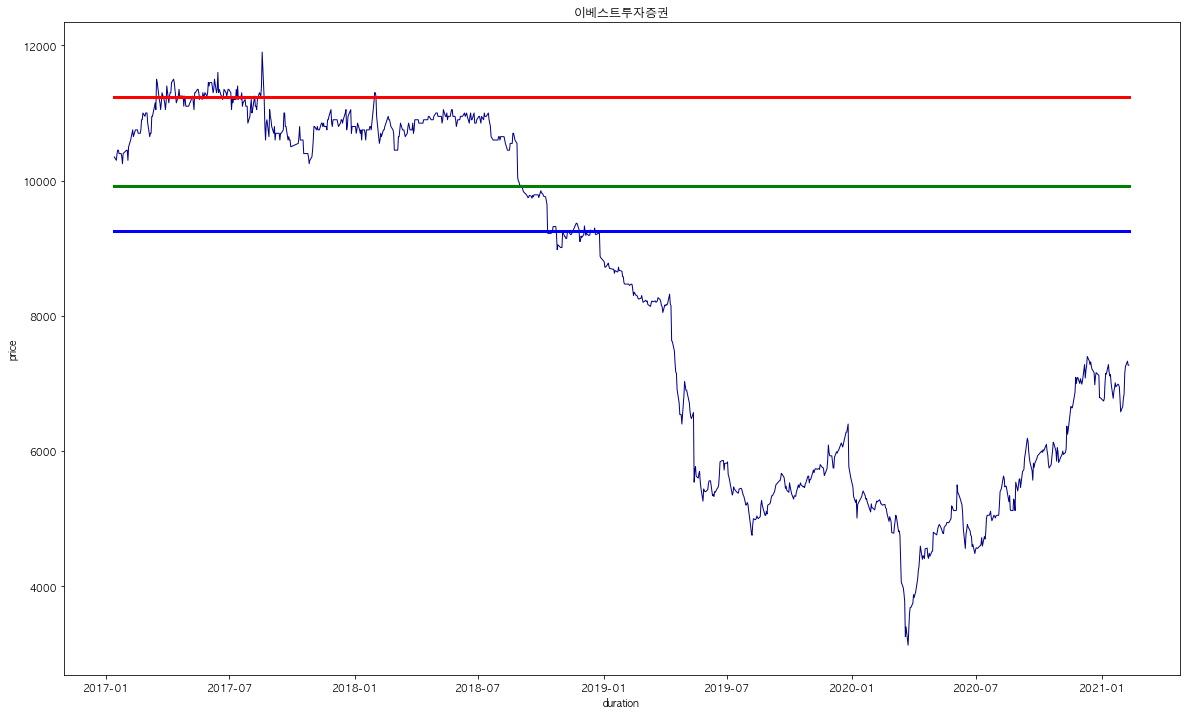

In [69]:
for company_name in company_list:
    show_more_adequate_price_chart(company_name, companies)